<a href="https://colab.research.google.com/github/IndraniMandal/New-Revisions/blob/main/Model_Interpreatability_pancreatic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def classification_confint(acc, n):
    '''
    Compute the 95% confidence interval for a classification problem.
      acc -- classification accuracy
      n   -- number of observations used to compute the accuracy
    Returns a tuple (lb,ub)
    '''
    import math
    interval = 1.96*math.sqrt(acc*(1-acc)/n)
    lb = max(0, acc - interval)
    ub = min(1.0, acc + interval)
    return (lb,ub)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
df_filled = pd.read_csv("https://raw.githubusercontent.com/dpereztorres/2023WinterInternship/main/pancreas_df_filled.csv")
df_filled.head()

,patient_cohort,sample_origin,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,Cohort1,BPTB,33,F,1,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,Cohort1,BPTB,81,F,1,9.0,0.97266,2.037585,94.46703,209.488250,228.407
2,Cohort2,BPTB,51,M,1,7.0,0.78039,0.145589,102.36600,461.141000,0.000
3,Cohort2,BPTB,61,M,1,8.0,0.70122,0.002805,60.57900,142.950000,0.000
4,Cohort2,BPTB,62,M,1,9.0,0.21489,0.000860,65.54000,41.088000,0.000


In [ ]:
df_filled['diagnosis'] = df_filled['diagnosis'].replace([1,2,3], [0,0,1])

In [ ]:
X  = df_filled.drop(['patient_cohort','sample_origin', 'sex', 'diagnosis'],axis=1)
y = df_filled['diagnosis']

print("Shape: {}".format(X.shape))

Shape: (590, 7)


In [ ]:
#From the model selection library import the function for splitting the dataset into train and test sets
from sklearn.model_selection import train_test_split 

# Split the dataset (80% for train set and 20% in test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
def balanced_accuracy_score(model, X_train, X_test, y_train): 
  from sklearn.metrics import balanced_accuracy_score
 
  model.fit(X_train, y_train)
  # Prediction using Testing data
  pred_test = model.predict(X_test)
  #calculate the balanced accuracy by comparing the true testing target and the predicted values
  return balanced_accuracy_score(y_test, pred_test)

## Logistic regression

In [ ]:
# import kFold and cross validation score
from sklearn.model_selection import KFold, cross_val_score
#From the model selection library import logistic regression
from sklearn.linear_model import LogisticRegression

# do the 5-fold cross validation and shuffle the data
cv = KFold(n_splits=5,  shuffle = True)

#models is a logistic regression model
lr=LogisticRegression(random_state=0, max_iter=10000) #maximum iteration is set to a high value of 10,000

scores = cross_val_score(lr, X_train, y_train,cv=cv)

print("Fold Accuracies: {}".format(scores))
lr_mean_score=scores.mean()
lr_balanced_acc=balanced_accuracy_score(lr, X_train, X_test, y_train)

Fold Accuracies: [0.88421053 0.89473684 0.87234043 0.90425532 0.91489362]


## Random Forest

In [ ]:
# import kFold and cross validation score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# do the 5-fold cross validation and shuffle the data
cv = KFold(n_splits=5,  shuffle = True)

rf = RandomForestClassifier(random_state=42)

scores = cross_val_score(rf, X_train, y_train,cv=cv)

print("Fold Accuracies: {}".format(scores))
rf_mean_score=scores.mean()
rf_balanced_acc=balanced_accuracy_score(rf, X_train, X_test, y_train)

Fold Accuracies: [0.87368421 0.89473684 0.87234043 0.90425532 0.94680851]


## XGBoost

In [ ]:
import xgboost
# import kFold and cross validation score
from sklearn.model_selection import KFold, cross_val_score

# XGBClassifier
xgb = xgboost.XGBClassifier(random_state=42)

# do the 5-fold cross validation and shuffle the data
cv = KFold(n_splits=5,  shuffle = True)

scores = cross_val_score(xgb, X_train, y_train,cv=cv)

print("Fold Accuracies: {}".format(scores))
xgb_mean_score=scores.mean()
xgb_balanced_acc=balanced_accuracy_score(xgb, X_train, X_test, y_train)

Fold Accuracies: [0.86315789 0.85263158 0.92553191 0.86170213 0.94680851]


In [ ]:
acc_scores = pd.DataFrame([ [lr_mean_score, lr_balanced_acc],[rf_mean_score, rf_balanced_acc],[xgb_mean_score, xgb_balanced_acc] ],  columns=['Mean Accuracy', 'Balanced accuracy'], 
                      index =['Logistic Regression', 'Random Forest', 'XGBoost'] )
acc_scores

,Mean Accuracy,Balanced accuracy
Logistic Regression,0.894087,0.884868
Random Forest,0.898365,0.910526
XGBoost,0.889966,0.909211


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.0 MB/s eta 0:00:00


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


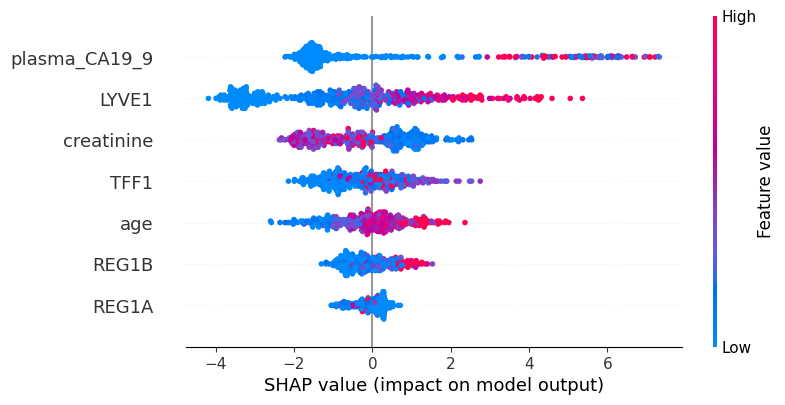

In [ ]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)